<h1 align="center" style="margin-top:10px">QBUS6810 Statistical Learning and Data Mining</h1>
<h2 align="center" style="margin-top:10px">Semester 1, 2021</h2>
<h2 align="center" style="margin-top:10px">Group Project: Airbnb Pricing Predictions</h2>
<h3 align="right" style="margin-top:10px">Group Number: 272</h3>
<br>

In [1]:
# Packages
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore') 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
import xgboost as xgb
from mlxtend.regressor import StackingCVRegressor
from sklearn.tree import export_graphviz

In [2]:
# Read in csv files and plot top of training data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,Id,price,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_identity_verified,latitude,longitude,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
0,2000,199,within an hour,1.00,1.00,t,5,f,-33.918732,151.242035,...,10.0,9.0,10.0,10.0,10.0,t,flexible,f,f,0.23
1,2001,95,NaN,NaN,0.83,t,1,f,-33.698425,151.290979,...,10.0,10.0,10.0,10.0,10.0,t,moderate,f,f,0.83
2,2002,156,within an hour,0.91,0.98,f,8,f,-33.847388,151.072890,...,9.0,10.0,10.0,10.0,9.0,f,strict_14_with_grace_period,f,f,6.90
3,2003,100,within an hour,0.99,0.97,f,260,f,-33.870261,151.195131,...,10.0,10.0,10.0,10.0,10.0,t,strict_14_with_grace_period,f,f,1.32
4,2004,100,within a day,1.00,NaN,f,1,f,-33.908168,151.211849,...,NaN,NaN,NaN,NaN,NaN,f,moderate,f,f,0.07


In [3]:
train.isnull().sum()

Id                                    0
price                                 0
host_response_time                  935
host_response_rate                  935
host_acceptance_rate                713
host_is_superhost                     0
host_listings_count                   0
host_identity_verified                0
latitude                              0
longitude                             0
property_type                         0
room_type                             0
accommodates                          0
bathrooms                             0
bedrooms                              2
beds                                 12
bed_type                              0
security_deposit                    707
cleaning_fee                        523
guests_included                       0
extra_people                          0
minimum_nights                        0
maximum_nights                        0
number_of_reviews                     0
review_scores_rating                491


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 36 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Id                                2000 non-null   int64  
 1   price                             2000 non-null   int64  
 2   host_response_time                1065 non-null   object 
 3   host_response_rate                1065 non-null   float64
 4   host_acceptance_rate              1287 non-null   float64
 5   host_is_superhost                 2000 non-null   object 
 6   host_listings_count               2000 non-null   int64  
 7   host_identity_verified            2000 non-null   object 
 8   latitude                          2000 non-null   float64
 9   longitude                         2000 non-null   float64
 10  property_type                     2000 non-null   object 
 11  room_type                         2000 non-null   object 
 12  accomm

In [5]:
# Get dimensions of the data
dim_train = np.shape(train)
print("Training data dimensions", dim_train)

# Note we have one less dimension in testing data as there is no response variable
dim_test = np.shape(test)
print("Testing data dimensions", dim_test) 

Training data dimensions (2000, 36)
Testing data dimensions (2000, 35)


### Data processing

Dealing with missing values  - method 1

In [6]:
train = train.fillna(method = 'bfill', axis = 0).fillna(train.mean())
test = test.fillna(method = 'bfill', axis = 0).fillna(test.mean()).fillna(method = 'ffill', axis = 0)

Dealing with missing values - method 2

In [7]:
# Deal with missing data by filling NA with string value: 'no reply'
train['host_response_time'].fillna('no reply', inplace = True)
test['host_response_time'].fillna('no reply', inplace = True)

# Deal with missing data by filling NA with a 0 value
train['host_response_rate'].fillna(0, inplace = True)
test['host_response_rate'].fillna(0, inplace = True)

# Deal with missing data by taking column mean
l_1 = ['host_acceptance_rate','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','reviews_per_month']
for i in l_1:
    train[i].fillna(train[i].mean(), inplace=True)
    test[i].fillna(test[i].mean(), inplace=True)

# Deal with missing data by taking column median
l_2 = ['bedrooms','beds','security_deposit','cleaning_fee']
for i in l_2:
    train[i].fillna(train[i].median(), inplace=True)
    test[i].fillna(test[i].median(), inplace=True)

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 35 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Id                                2000 non-null   int64  
 1   host_response_time                2000 non-null   object 
 2   host_response_rate                2000 non-null   float64
 3   host_acceptance_rate              2000 non-null   float64
 4   host_is_superhost                 2000 non-null   object 
 5   host_listings_count               2000 non-null   int64  
 6   host_identity_verified            2000 non-null   object 
 7   latitude                          2000 non-null   float64
 8   longitude                         2000 non-null   float64
 9   property_type                     2000 non-null   object 
 10  room_type                         2000 non-null   object 
 11  accommodates                      2000 non-null   int64  
 12  bathro

Dealing with boolean variables

In [9]:
# Convert true/false to 1/0
l_3 = ['host_is_superhost', 'host_identity_verified','instant_bookable','require_guest_profile_picture','require_guest_phone_verification']
for i in l_3:
    train[i] = train[i].replace('t', 1)
    train[i] = train[i].replace('f', 0)
    test[i] = test[i].replace('t', 1)
    test[i] = test[i].replace('f', 0)

In [10]:
train.head()

,Id,price,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_identity_verified,latitude,longitude,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
0,2000,199,within an hour,1.00,1.00,1,5,0,-33.918732,151.242035,...,10.0,9.0,10.0,10.0,10.0,1,flexible,0,0,0.23
1,2001,95,within an hour,0.91,0.83,1,1,0,-33.698425,151.290979,...,10.0,10.0,10.0,10.0,10.0,1,moderate,0,0,0.83
2,2002,156,within an hour,0.91,0.98,0,8,0,-33.847388,151.072890,...,9.0,10.0,10.0,10.0,9.0,0,strict_14_with_grace_period,0,0,6.90
3,2003,100,within an hour,0.99,0.97,0,260,0,-33.870261,151.195131,...,10.0,10.0,10.0,10.0,10.0,1,strict_14_with_grace_period,0,0,1.32
4,2004,100,within a day,1.00,1.00,0,1,0,-33.908168,151.211849,...,9.0,9.0,9.0,9.0,10.0,0,moderate,0,0,0.07


Dealing with categorical variables

In [11]:
# Demonstrate frequency count for each category
for i in ['host_response_time', 'property_type', 'room_type', 'bed_type', 'cancellation_policy']:
    a = pd.crosstab(index=train[i], columns="count")
    print(a)
    print('-'*32)

col_0               count
host_response_time       
a few days or more     71
within a day          216
within a few hours    330
within an hour       1383
--------------------------------
col_0               count
property_type            
Apartment            1327
Bed and breakfast       2
Boat                    2
Boutique hotel         10
Bungalow                6
Cabin                   6
Camper/RV               1
Condominium            34
Cottage                 7
Farm stay               1
Guest suite            34
Guesthouse             28
Hostel                  3
Hotel                   2
House                 423
Loft                    9
Other                   2
Serviced apartment      9
Tent                    1
Tiny house              2
Townhouse              78
Treehouse               1
Villa                  12
--------------------------------
col_0            count
room_type             
Entire home/apt   1284
Hotel room          16
Private room       677
Shared room  

In [12]:
# Encode smaller number of categorical variables
train['property_type'] = np.where(train['property_type'].str.contains('House'), "House", (np.where(train['property_type'].str.contains('Apartment'), "Apartment", (np.where(train['property_type'].str.contains('Townhouse'), "Townhouse", "Other")))))
test['property_type'] = np.where(test['property_type'].str.contains('House'), "House", (np.where(test['property_type'].str.contains('Apartment'), "Apartment", (np.where(test['property_type'].str.contains('Townhouse'), "Townhouse", "Other")))))

train['bed_type'] = np.where(train['bed_type'].str.contains('Real Bed'), "Real Bed", "Other")
test['bed_type'] = np.where(test['bed_type'].str.contains('Real Bed'), "Real Bed", "Other")

train['cancellation_policy'] = np.where(train['cancellation_policy'].str.contains('flexible'), "flexible", (np.where(train['cancellation_policy'].str.contains('moderate'), "moderate", "strict")))
test['cancellation_policy'] = np.where(test['cancellation_policy'].str.contains('flexible'), "flexible", (np.where(test['cancellation_policy'].str.contains('moderate'), "moderate", "strict")))


In [13]:
# Check the result of encoding
for i in ['host_response_time', 'property_type', 'room_type', 'bed_type', 'cancellation_policy']:
    a = pd.crosstab(index=train[i], columns="count")
    print(a)
    print('-'*32)

col_0               count
host_response_time       
a few days or more     71
within a day          216
within a few hours    330
within an hour       1383
--------------------------------
col_0          count
property_type       
Apartment       1327
House            423
Other            172
Townhouse         78
--------------------------------
col_0            count
room_type             
Entire home/apt   1284
Hotel room          16
Private room       677
Shared room         23
--------------------------------
col_0     count
bed_type       
Other        15
Real Bed   1985
--------------------------------
col_0                count
cancellation_policy       
flexible               662
moderate               498
strict                 840
--------------------------------


Dealing with ordinal categorical variables (optional)

In [14]:
# Rate the 'host_response_time' and 'cancellation_policy'
train['host_response_time'] = train.host_response_time.map({'no reply':0, 'a few days or more':1, 'within a day':2, 'within a few hours':3, 'within an hour':4})
test['host_response_time'] = test.host_response_time.map({'no reply':0, 'a few days or more':1, 'within a day':2, 'within a few hours':3, 'within an hour':4})

train['cancellation_policy'] = train.cancellation_policy.map({'flexible':0， 'moderate':1, 'strict':2})
test['cancellation_policy'] = test.cancellation_policy.map('flexible':0， 'moderate':1, 'strict':2})

In [15]:
train.head()

,Id,price,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_identity_verified,latitude,longitude,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
0,2000,199,within an hour,1.00,1.00,1,5,0,-33.918732,151.242035,...,10.0,9.0,10.0,10.0,10.0,1,flexible,0,0,0.23
1,2001,95,within an hour,0.91,0.83,1,1,0,-33.698425,151.290979,...,10.0,10.0,10.0,10.0,10.0,1,moderate,0,0,0.83
2,2002,156,within an hour,0.91,0.98,0,8,0,-33.847388,151.072890,...,9.0,10.0,10.0,10.0,9.0,0,strict,0,0,6.90
3,2003,100,within an hour,0.99,0.97,0,260,0,-33.870261,151.195131,...,10.0,10.0,10.0,10.0,10.0,1,strict,0,0,1.32
4,2004,100,within a day,1.00,1.00,0,1,0,-33.908168,151.211849,...,9.0,9.0,9.0,9.0,10.0,0,moderate,0,0,0.07


Generate dummy variables

In [16]:
train = pd.get_dummies(train, drop_first = True)
test = pd.get_dummies(test, drop_first = True)

In [17]:
train.head()

,Id,price,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_identity_verified,latitude,longitude,accommodates,...,host_response_time_within an hour,property_type_House,property_type_Other,property_type_Townhouse,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict
0,2000,199,1.00,1.00,1,5,0,-33.918732,151.242035,2,...,1,0,1,0,1,0,0,1,0,0
1,2001,95,0.91,0.83,1,1,0,-33.698425,151.290979,4,...,1,0,1,0,0,0,0,1,1,0
2,2002,156,0.91,0.98,0,8,0,-33.847388,151.072890,4,...,1,0,0,0,0,0,0,1,0,1
3,2003,100,0.99,0.97,0,260,0,-33.870261,151.195131,2,...,1,0,0,0,0,0,0,1,0,1
4,2004,100,1.00,1.00,0,1,0,-33.908168,151.211849,1,...,0,0,0,0,0,1,0,1,1,0


### EDA

In [18]:
# Split the clean training & testing data into responses and predictors
response = 'price'
predictors= list(train.columns.values[2:])

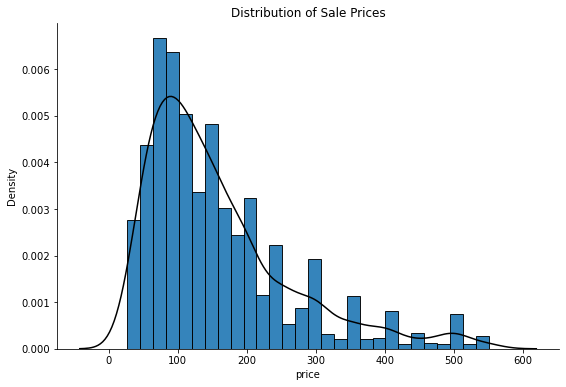

In [19]:
# Exploratory Data Analysis: histogram plots
from statlearning import plot_dist

plot_dist(train[response])
plt.title('Distribution of Sale Prices')
plt.show()

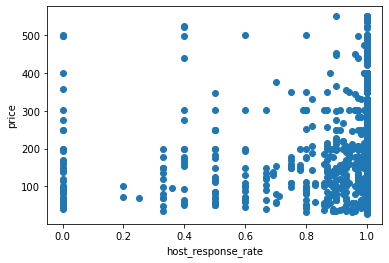

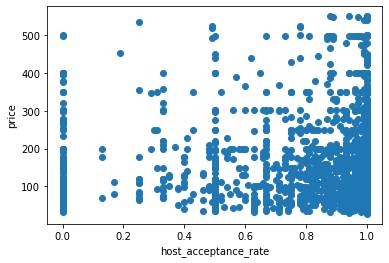

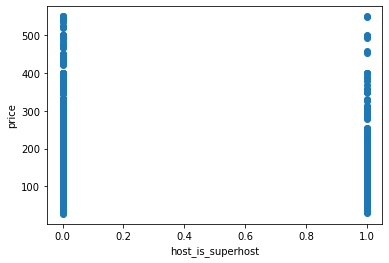

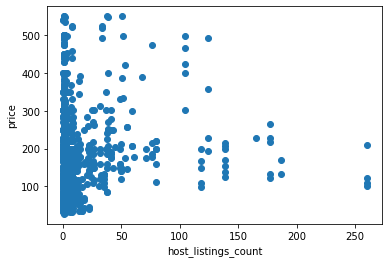

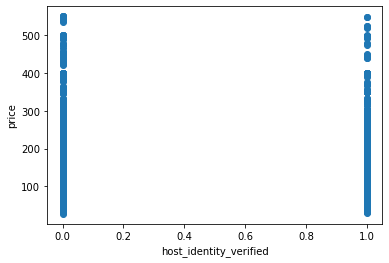

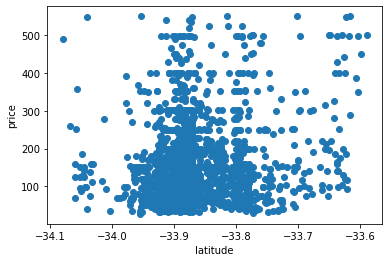

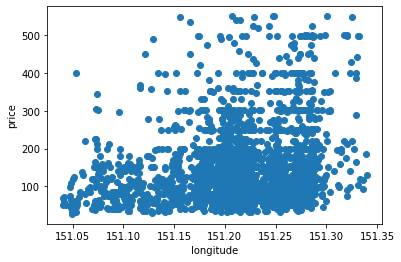

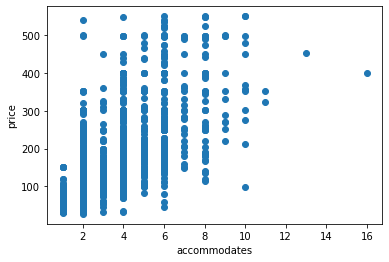

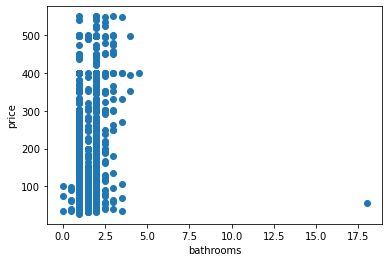

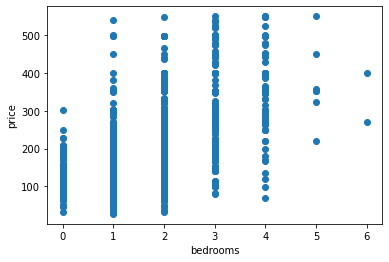

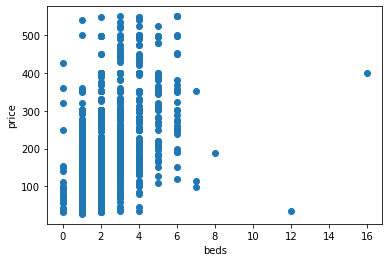

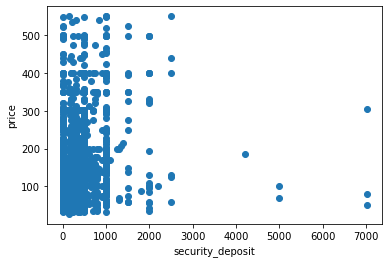

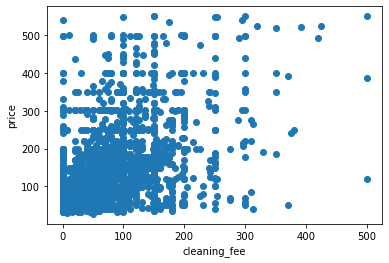

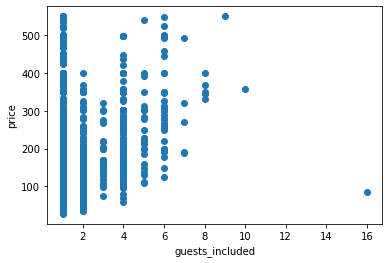

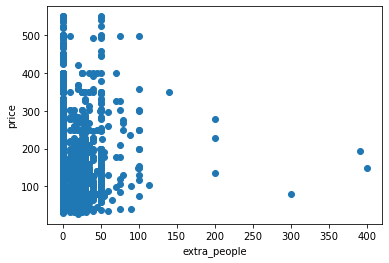

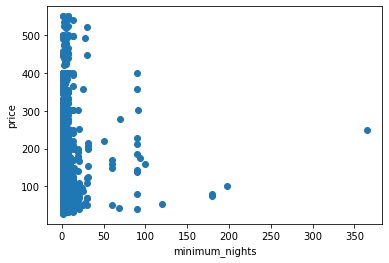

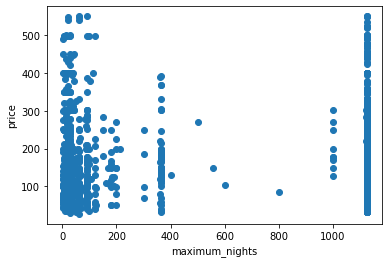

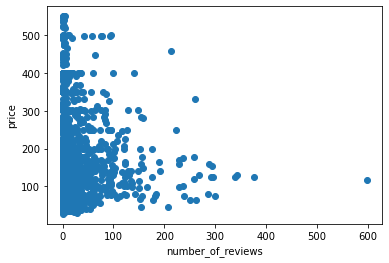

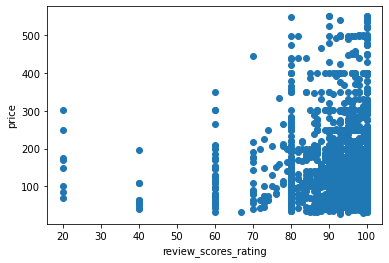

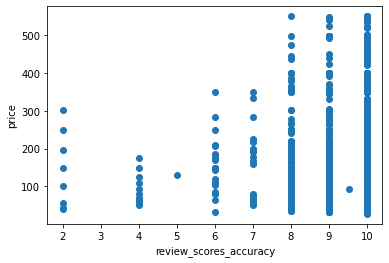

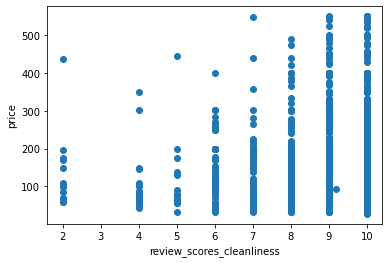

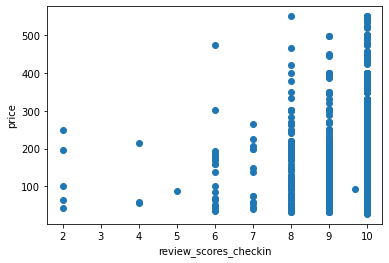

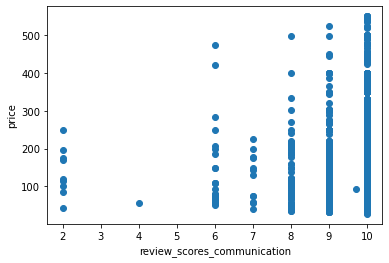

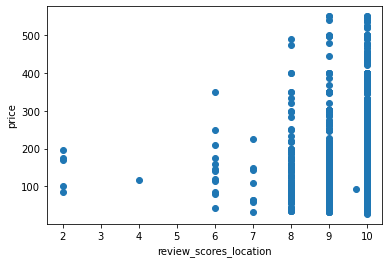

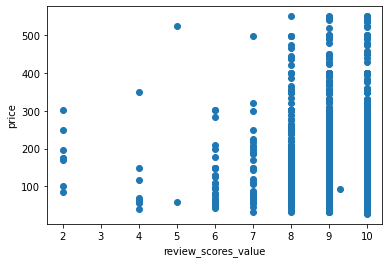

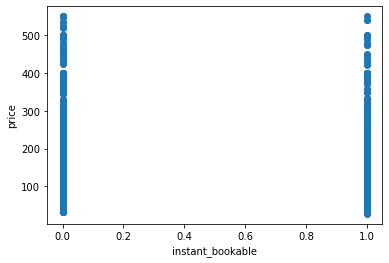

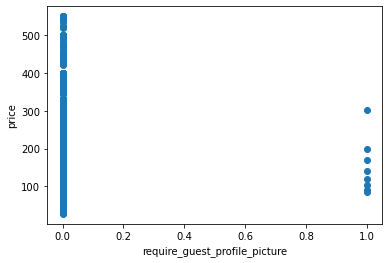

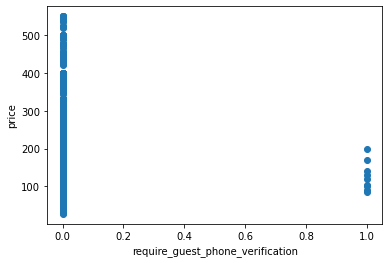

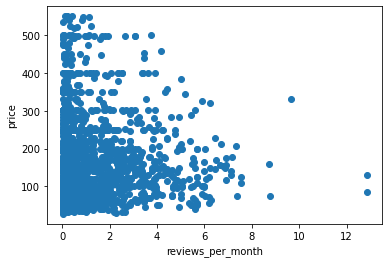

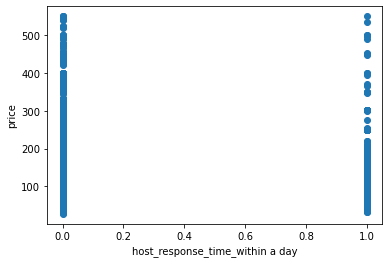

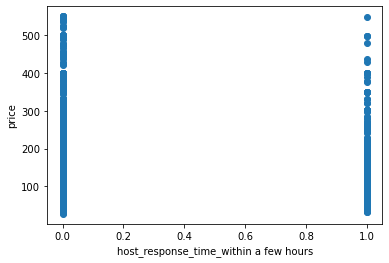

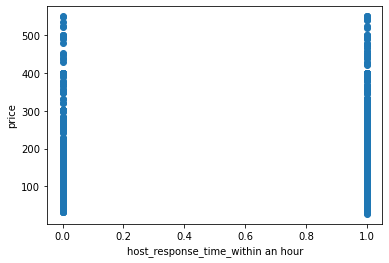

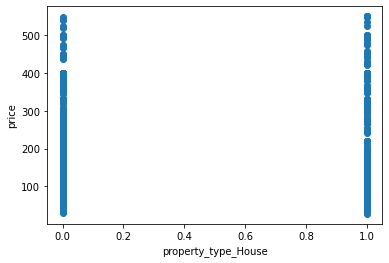

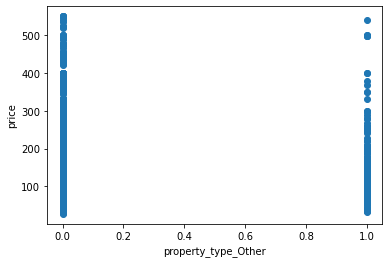

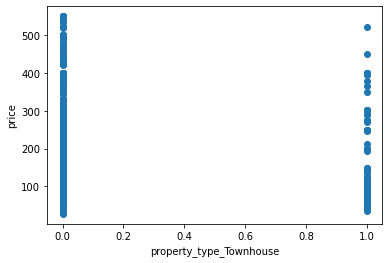

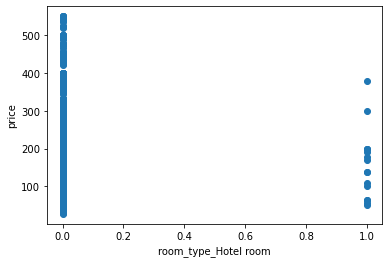

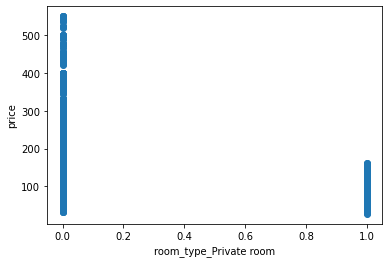

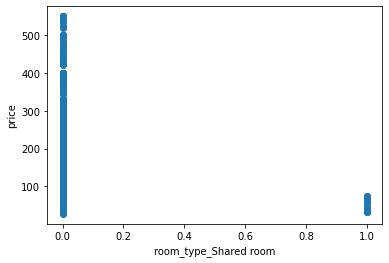

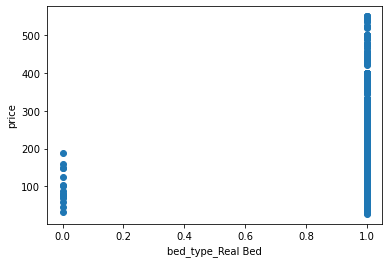

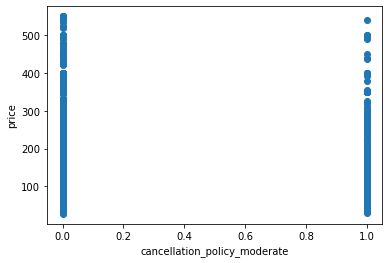

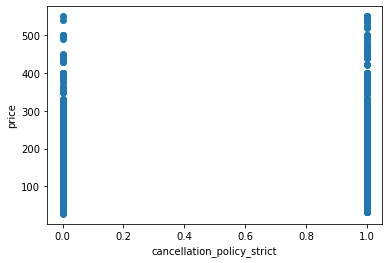

In [20]:
# Exploratory Data Analysis: scattor plots
for i in predictors:
    plt.scatter(train[i],train[response])
    plt.xlabel(str(i))
    plt.ylabel(str(response))
    plt.show()

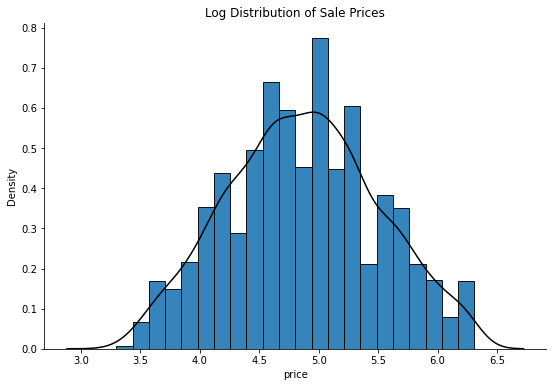

In [21]:
plot_dist(np.log(train[response]))
plt.title('Log Distribution of Sale Prices')
plt.show()

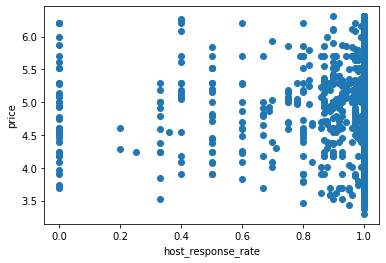

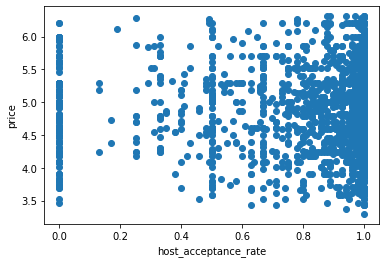

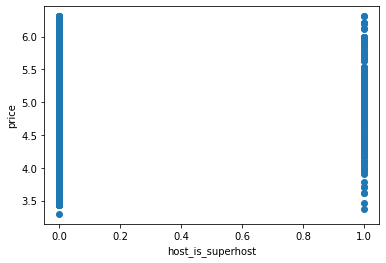

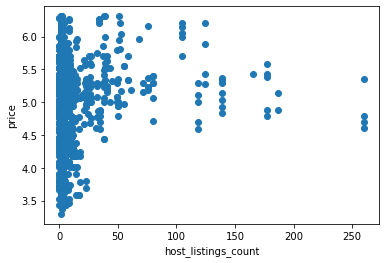

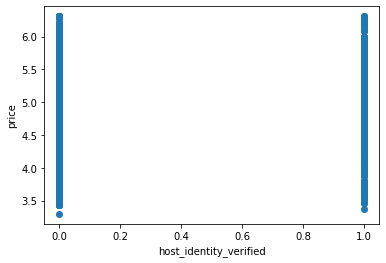

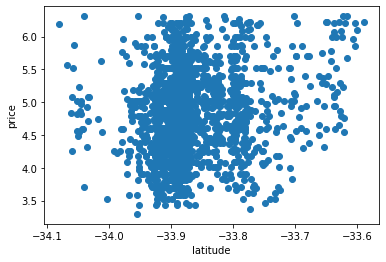

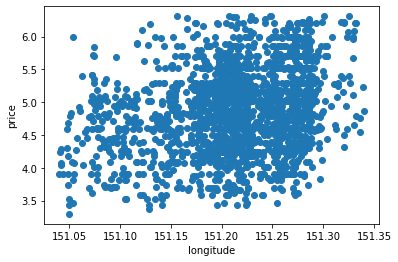

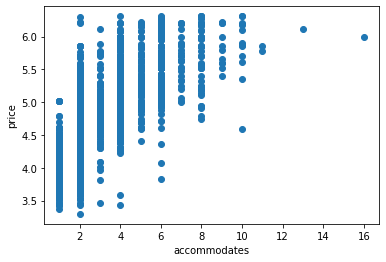

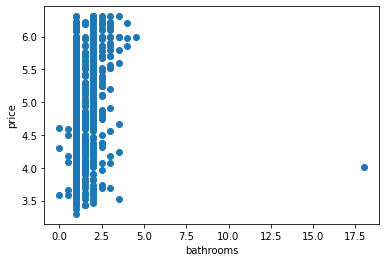

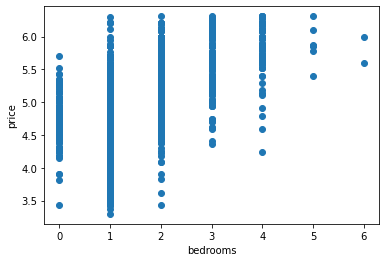

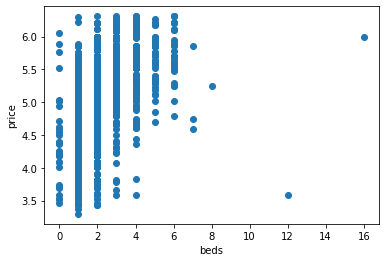

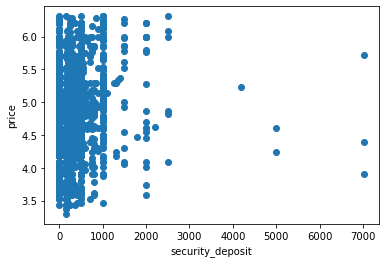

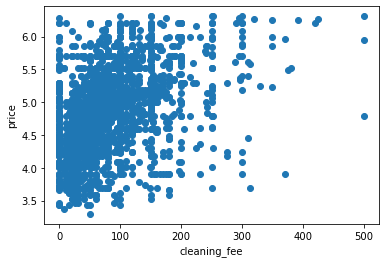

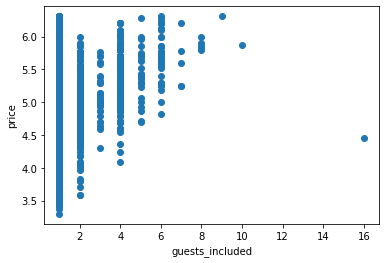

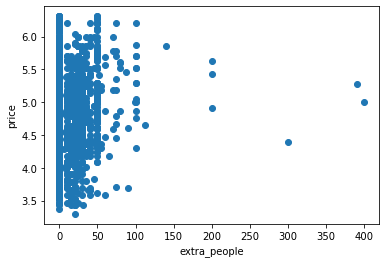

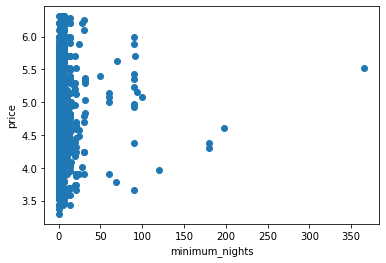

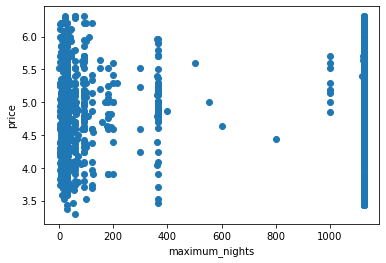

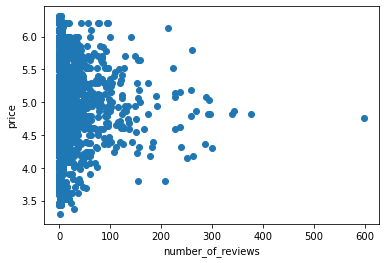

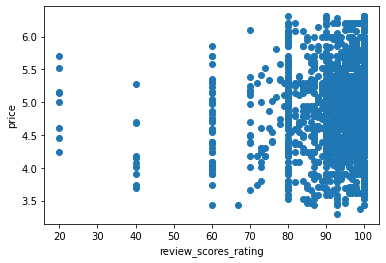

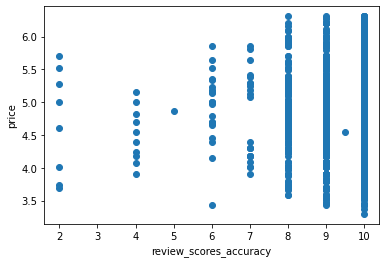

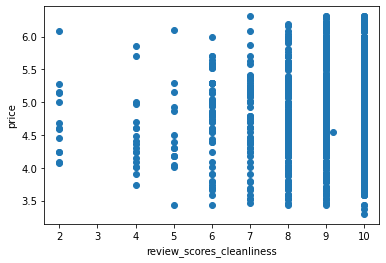

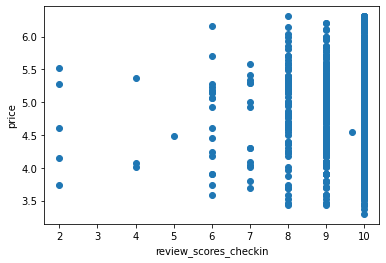

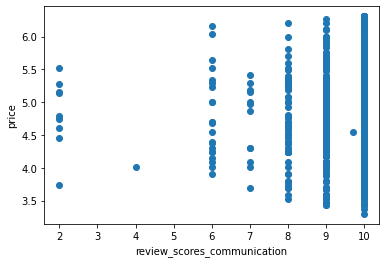

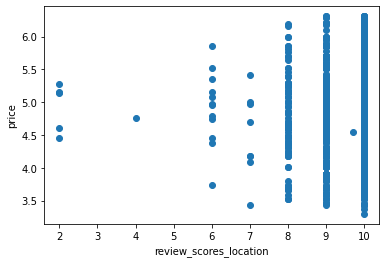

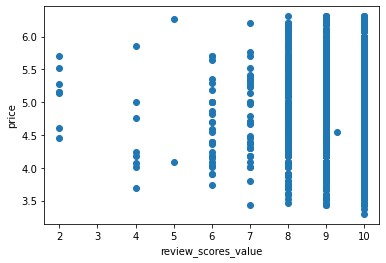

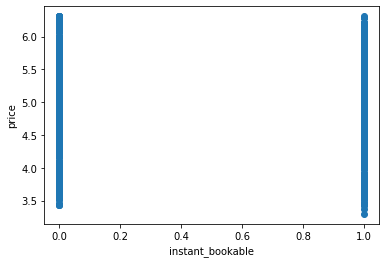

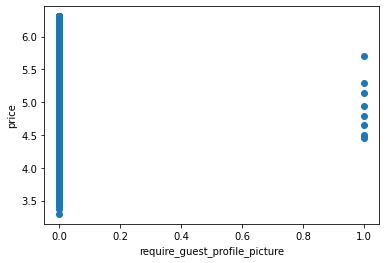

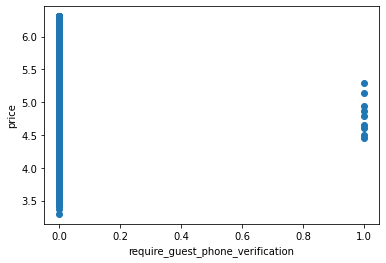

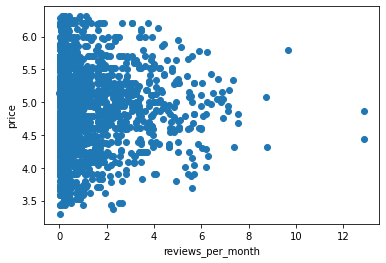

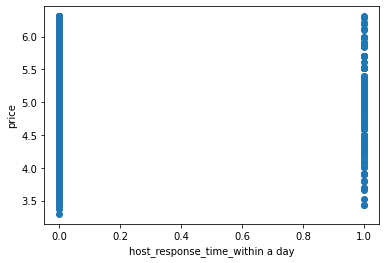

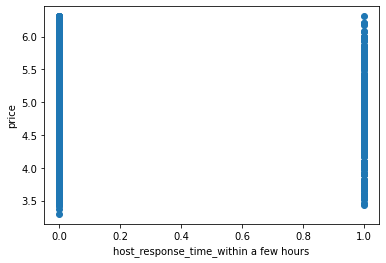

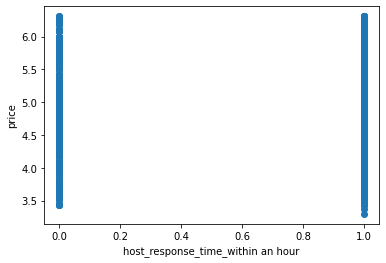

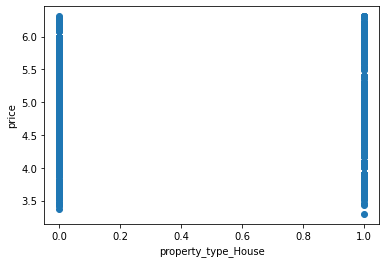

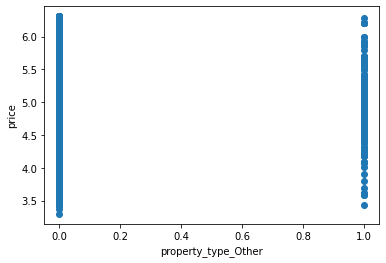

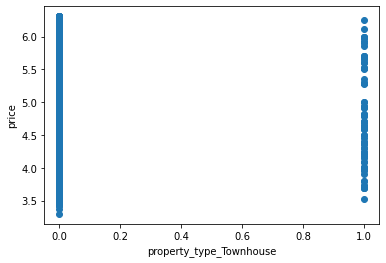

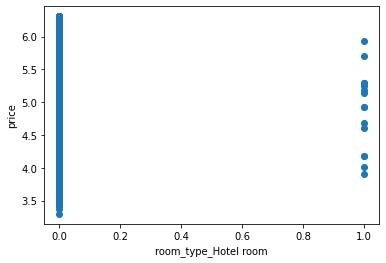

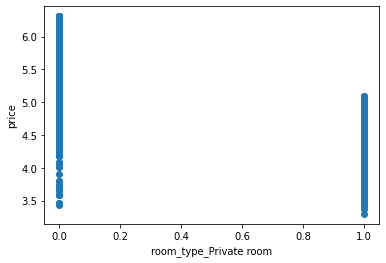

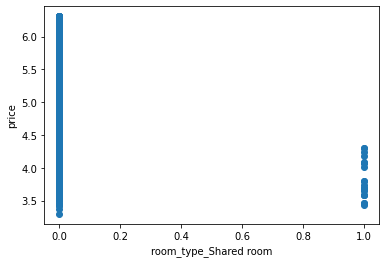

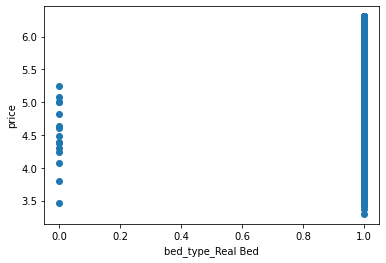

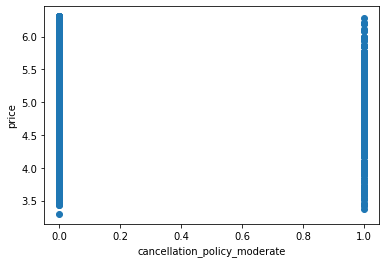

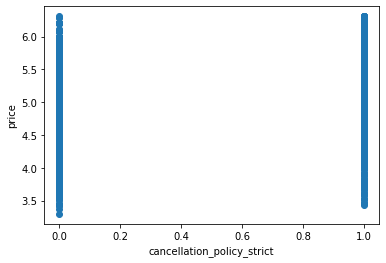

In [22]:
for i in predictors:
    plt.scatter(train[i],np.log(train[response]))
    plt.xlabel(str(i))
    plt.ylabel(str(response))
    plt.show()

### Feature Engineering

In [23]:
y_train = np.log(train[response]) 
X_train = train[predictors].copy()
X_test = test[predictors].copy()

In [24]:
X_train.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,...,host_response_time_within an hour,property_type_House,property_type_Other,property_type_Townhouse,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict
0,1.00,1.00,1,5,0,-33.918732,151.242035,2,1.0,0.0,...,1,0,1,0,1,0,0,1,0,0
1,0.91,0.83,1,1,0,-33.698425,151.290979,4,1.0,1.0,...,1,0,1,0,0,0,0,1,1,0
2,0.91,0.98,0,8,0,-33.847388,151.072890,4,1.0,2.0,...,1,0,0,0,0,0,0,1,0,1
3,0.99,0.97,0,260,0,-33.870261,151.195131,2,1.0,1.0,...,1,0,0,0,0,0,0,1,0,1
4,1.00,1.00,0,1,0,-33.908168,151.211849,1,1.0,1.0,...,0,0,0,0,0,1,0,1,1,0


#### Latitude & longtitude
Town_hall = (-33.87328012233736, 151.2071723690678)

Bondi_beach = (-33.89002106143414, 151.27734426490852)
 *adopted from Google Map*

In [25]:
X_train['r_townhall'] = np.sqrt((X_train['latitude']-(-33.87328012233736))**2 + (X_train['longitude']-151.2071723690678)**2)
X_test['r_townhall'] = np.sqrt((X_test['latitude']-(-33.87328012233736))**2 + (X_test['longitude']-151.2071723690678)**2)
X_train

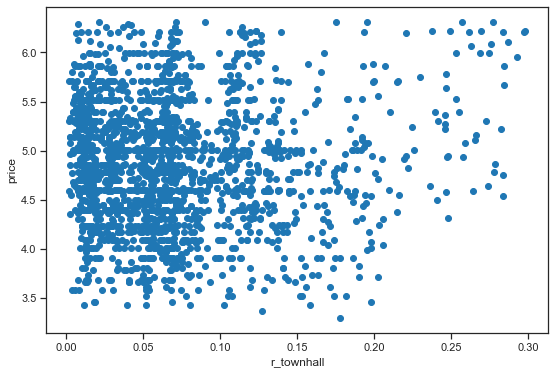

In [29]:
plt.scatter(X_train['r_townhall'],y_train)
plt.xlabel('r_townhall')
plt.ylabel('price')
plt.show()

In [26]:
X_train['r_bondi'] = np.sqrt((X_train['latitude']-(-33.89002106143414))**2 + (X_train['longitude']-151.27734426490852)**2)
X_test['r_bondi'] = np.sqrt((X_test['latitude']-(-33.89002106143414))**2 + (X_test['longitude']-151.27734426490852)**2)
X_train

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,...,property_type_House,property_type_Other,property_type_Townhouse,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict,r_bondi
0,1.00,1.00,1,5,0,-33.918732,151.242035,2,1.0,0.0,...,0,1,0,1,0,0,1,0,0,0.045509
1,0.91,0.83,1,1,0,-33.698425,151.290979,4,1.0,1.0,...,0,1,0,0,0,0,1,1,0,0.192080
2,0.91,0.98,0,8,0,-33.847388,151.072890,4,1.0,2.0,...,0,0,0,0,0,0,1,0,1,0.208852
3,0.99,0.97,0,260,0,-33.870261,151.195131,2,1.0,1.0,...,0,0,0,0,0,0,1,0,1,0.084554
4,1.00,1.00,0,1,0,-33.908168,151.211849,1,1.0,1.0,...,0,0,0,0,1,0,1,1,0,0.067962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.00,0.99,0,23,1,-33.881002,151.216918,2,1.0,1.0,...,0,0,1,0,1,0,1,0,1,0.061096
1996,1.00,0.95,0,9,0,-33.868943,151.191446,2,1.0,1.0,...,0,1,0,1,0,0,1,1,0,0.088447
1997,1.00,0.95,1,5,1,-33.885611,151.200060,2,1.0,1.0,...,0,0,0,0,0,0,1,0,1,0.077410
1998,0.80,0.50,0,3,1,-33.867824,151.170051,1,2.5,1.0,...,1,0,0,0,1,0,1,0,1,0.109565


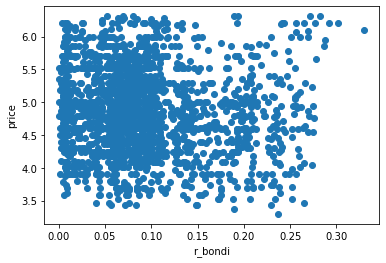

In [27]:
plt.scatter(X_train['r_bondi'],y_train)
plt.xlabel('r_bondi')
plt.ylabel('price')
plt.show()

### Model Building
OLS

In [25]:
ols = LinearRegression()
ols.fit(X_train, y_train)

LinearRegression()

In [26]:
# y_pred = np.exp(ols.predict(X_test))

# # Write out submission script in format appropriate for Kaggle
# submission = pd.DataFrame(np.c_[test.index, y_pred], columns=['Id', 'price'])
# submission['Id'] = submission['Id'].astype('int')
# submission.to_csv('kaggle_submission_ols.csv', index=False) 
# print(submission)

Ridge

In [27]:
%%time

alphas = list(np.logspace(-15, 15, 151, base=2))

ridge = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', RidgeCV(alphas=alphas, cv=5)),
))

ridge.fit(X_train, y_train)

Wall time: 1.18 s


Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator',
                 RidgeCV(alphas=array([3.05175781e-05, 3.50554918e-05, 4.02681858e-05, 4.62559987e-05,
       5.31341897e-05, 6.10351562e-05, 7.01109836e-05, 8.05363715e-05,
       9.25119975e-05, 1.06268379e-04, 1.22070312e-04, 1.40221967e-04,
       1.61072743e-04, 1.85023995e-04, 2.12536759e-04, 2.44140625e-04,
       2.80443934e-04, 3.22145486e-04, 3...
       1.55209376e+03, 1.78288755e+03, 2.04800000e+03, 2.35253423e+03,
       2.70235220e+03, 3.10418753e+03, 3.56577511e+03, 4.09600000e+03,
       4.70506846e+03, 5.40470440e+03, 6.20837506e+03, 7.13155021e+03,
       8.19200000e+03, 9.41013692e+03, 1.08094088e+04, 1.24167501e+04,
       1.42631004e+04, 1.63840000e+04, 1.88202738e+04, 2.16188176e+04,
       2.48335002e+04, 2.85262009e+04, 3.27680000e+04]),
                         cv=5))])

In [28]:
# y_pred = np.exp(ridge.predict(X_test))

# # Write out submission script in format appropriate for Kaggle
# submission = pd.DataFrame(np.c_[test.index, y_pred], columns=['Id', 'price'])
# submission['Id'] = submission['Id'].astype('int')
# submission.to_csv('kaggle_submission_ridge.csv', index=False) 
# print(submission)

Lasso

In [29]:
%%time
lasso = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', LassoCV(cv=5)),
))
lasso.fit(X_train, y_train)

Wall time: 77.8 ms


Pipeline(steps=[('scaler', StandardScaler()), ('estimator', LassoCV(cv=5))])

In [30]:
# y_pred = np.exp(lasso.predict(X_test))

# # Write out submission script in format appropriate for Kaggle
# submission = pd.DataFrame(np.c_[test.index, y_pred], columns=['Id', 'price'])
# submission['Id'] = submission['Id'].astype('int')
# submission.to_csv('kaggle_submission_lasso.csv', index=False) 
# print(submission)

Enet

In [31]:
%%time

enet = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', ElasticNetCV(l1_ratio=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 0.99], cv=5)),
))

enet.fit(X_train, y_train)

Wall time: 697 ms


Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator',
                 ElasticNetCV(cv=5,
                              l1_ratio=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                        0.8, 0.9, 0.99]))])

In [32]:
# y_pred = np.exp(enet.predict(X_test))

# # Write out submission script in format appropriate for Kaggle
# submission = pd.DataFrame(np.c_[test.index, y_pred], columns=['Id', 'price'])
# submission['Id'] = submission['Id'].astype('int')
# submission.to_csv('kaggle_submission_enet.csv', index=False) 
# print(submission)

Tree

In [33]:
%%time

model = DecisionTreeRegressor(min_samples_leaf=5)

tuning_parameters = {
    'min_samples_leaf': [1,5,10,20],
    'max_depth': np.arange(1,30),
}

tree = RandomizedSearchCV(model, tuning_parameters, n_iter=20, cv=5, return_train_score=False)
tree.fit(X_train, y_train)

print('Best parameters:', tree.best_params_)

Best parameters: {'min_samples_leaf': 10, 'max_depth': 4}
Wall time: 1.09 s


In [34]:
model_plot = DecisionTreeRegressor(max_depth=6, min_samples_leaf=20)
tuning_parameters_plot = {
    'min_samples_leaf': [20],
    'max_depth': [6],
}
tree_plot = RandomizedSearchCV(model_plot, tuning_parameters_plot, n_iter=20, cv=5, return_train_score=False)
tree_plot.fit(X_train, y_train)
best_estimator_plot = tree_plot.best_estimator_
dot_data = export_graphviz(best_estimator_plot)
print(dot_data)

digraph Tree {
node [shape=box] ;
0 [label="X[36] <= 0.5\nmse = 0.398\nsamples = 2000\nvalue = 4.869"] ;
1 [label="X[9] <= 1.5\nmse = 0.254\nsamples = 1323\nvalue = 5.174"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="X[37] <= 0.5\nmse = 0.186\nsamples = 626\nvalue = 4.91"] ;
1 -> 2 ;
3 [label="X[12] <= 72.5\nmse = 0.143\nsamples = 603\nvalue = 4.951"] ;
2 -> 3 ;
4 [label="X[6] <= 151.263\nmse = 0.129\nsamples = 313\nvalue = 4.866"] ;
3 -> 4 ;
5 [label="X[30] <= 0.5\nmse = 0.108\nsamples = 236\nvalue = 4.806"] ;
4 -> 5 ;
6 [label="mse = 0.113\nsamples = 191\nvalue = 4.839"] ;
5 -> 6 ;
7 [label="mse = 0.066\nsamples = 45\nvalue = 4.664"] ;
5 -> 7 ;
8 [label="X[24] <= 9.5\nmse = 0.146\nsamples = 77\nvalue = 5.048"] ;
4 -> 8 ;
9 [label="mse = 0.141\nsamples = 39\nvalue = 5.168"] ;
8 -> 9 ;
10 [label="mse = 0.121\nsamples = 38\nvalue = 4.925"] ;
8 -> 10 ;
11 [label="X[6] <= 151.188\nmse = 0.143\nsamples = 290\nvalue = 5.044"] ;
3 -> 11 ;
12 [label="X[28] <= 0.9

In [35]:
# y_pred = np.exp(tree.predict(X_test))

# # Write out submission script in format appropriate for Kaggle
# submission = pd.DataFrame(np.c_[test.index, y_pred], columns=['Id', 'price'])
# submission['Id'] = submission['Id'].astype('int')
# submission.to_csv('kaggle_submission_tree.csv', index=False) 
# print(submission)

XGBoost(xbst)

In [36]:
%%time

model = xgb.XGBRegressor()

tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2, 3, 4],
    'subsample' : [0.6, 0.8, 1.0],
}

gb_search = RandomizedSearchCV(model, tuning_parameters, n_iter = 1, cv = 5, return_train_score=False, n_jobs=4,
                              random_state = 20)
gb_search.fit(X_train, y_train)

xbst = gb_search.best_estimator_

print('Best parameters found by randomised search:', gb_search.best_params_, '\n')

Best parameters found by randomised search: {'subsample': 0.6, 'n_estimators': 1000, 'max_depth': 2, 'learning_rate': 0.1} 

Wall time: 3.68 s


In [37]:
# y_pred = np.exp(xbst.predict(X_test))

# # Write out submission script in format appropriate for Kaggle
# submission = pd.DataFrame(np.c_[test.index, y_pred], columns=['Id', 'price'])
# submission['Id'] = submission['Id'].astype('int')
# submission.to_csv('kaggle_submission_xbst.csv', index=False) 
# print(submission)

Additive Boost(abst)

In [38]:
%%time
y_fit = lasso.predict(X_train)
resid = y_train - y_fit

model = xgb.XGBRegressor()

tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2, 3, 4],
    'subsample' : [0.6, 0.8, 1.0],
}

gb_search = RandomizedSearchCV(model, tuning_parameters, n_iter = 16, cv = 5, return_train_score=False, n_jobs=4,
                              random_state = 20)
gb_search.fit(X_train, resid)

abst = gb_search.best_estimator_

print('Best parameters found by randomised search:', gb_search.best_params_, '\n')

Best parameters found by randomised search: {'subsample': 0.8, 'n_estimators': 750, 'max_depth': 4, 'learning_rate': 0.01} 

Wall time: 20.4 s


In [39]:
# y_pred=np.exp(lasso.predict(X_test)+abst.predict(X_test))

# # Write out submission script in format appropriate for Kaggle
# submission = pd.DataFrame(np.c_[test.index, y_pred], columns=['Id', 'price'])
# submission['Id'] = submission['Id'].astype('int')
# submission.to_csv('kaggle_submission_abst.csv', index=False) 
# print(submission)

Stack

In [40]:
%%time

models = [ols, lasso, ridge, xbst]

stack = StackingCVRegressor(models, meta_regressor = LinearRegression(), cv = 10)
stack.fit(X_train.values, y_train.ravel())

Wall time: 18.9 s


StackingCVRegressor(cv=10, meta_regressor=LinearRegression(),
                    regressors=[LinearRegression(),
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('estimator', LassoCV(cv=5))]),
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('estimator',
                                                 RidgeCV(alphas=array([3.05175781e-05, 3.50554918e-05, 4.02681858e-05, 4.62559987e-05,
       5.31341897e-05, 6.10351562e-05, 7.01109836e-05, 8...
                                             colsample_bytree=1, gamma=0,
                                             gpu_id=-1, importance_type='gain',
                                             interaction_constraints='',
                                             learning_rate=0.1,
                                             max_delta_step=0, max_depth=2,
                          

In [41]:
y_pred=np.exp(stack.predict(X_test.values))

# Write out submission script in format appropriate for Kaggle
submission = pd.DataFrame(np.c_[test.index, y_pred], columns=['Id', 'price'])
submission['Id'] = submission['Id'].astype('int')
submission.to_csv('kaggle_submission_stack3.csv', index=False) 
print(submission)

        Id       price
0        0   63.302311
1        1  189.150660
2        2  141.166167
3        3   75.354429
4        4  121.590878
...    ...         ...
1995  1995  286.605197
1996  1996  270.649212
1997  1997  135.114514
1998  1998   73.516091
1999  1999   74.196956

[2000 rows x 2 columns]
